# 피쳐선정
---

In [3]:
# 라이브러리 로드

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter('ignore')


# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

# 차트에 마이너스 출력
plt.rcParams['axes.unicode_minus'] = False

# 지수로 출력되는 값 없애기
pd.options.display.float_format = '{:.5f}'.format

In [4]:
# 로우데이터 로드
df = pd.read_csv('./datasets/Raw_data.csv')

In [5]:
df_remain = df[['신용등급', '대출조회횟수', '2년연체횟수', '공공기록', '완전대출여부', '목적_credit_card',
       '목적_debt_consolidation', '목적_educational', '목적_home_improvement',
       '목적_major_purchase', '목적_small_business']]

In [6]:
# 데이터 분할(8:2)
X = df.drop(columns=['신용등급', '대출조회횟수', '2년연체횟수', '공공기록', '완전대출여부', '목적_credit_card',
       '목적_debt_consolidation', '목적_educational', '목적_home_improvement',
       '목적_major_purchase', '목적_small_business', '등급'], axis=1)
y = df[['등급']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Standard Scaling

In [7]:
## Train set 스케일링
# StandardScaler객체 생성
scaler_stan = StandardScaler()
scaler_stan.fit(X_train)
data_scaled_stan = scaler_stan.transform(X_train)

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_train_stan = pd.DataFrame(data = data_scaled_stan, columns=X_train.columns)

In [8]:
## Test set 스케일링
# StandardScaler객체 생성
scaler_stan = StandardScaler()
scaler_stan.fit(X_train)
data_scaled_stan = scaler_stan.transform(X_test)

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
X_test_stan = pd.DataFrame(data = data_scaled_stan, columns=X_test.columns)

In [9]:
X_train_raw = pd.merge(X_train_stan, df_remain, left_index=True ,right_index=True, how='inner')
X_test_raw = pd.merge(X_test_stan, df_remain, left_index=True ,right_index=True, how='inner')

### 피쳐선정 함수 (Stepwise, Lasso)
---

In [10]:
# Lasso

# 라쏘 피쳐셀렉에 사용할 최적 파라미터 설정
lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : [0.1, 0.2, 0.5, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid = df_grid.sort_values(by=['rank_test_score'], ascending=True)
df_grid[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]

,params,mean_train_score,mean_test_score,rank_test_score
6,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.74615,0.74406,1
5,"{'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}",0.74569,0.74393,2
4,"{'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}",0.74481,0.74354,3
3,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.74318,0.74276,4
2,"{'C': 0.5, 'penalty': 'l1', 'solver': 'libline...",0.73946,0.73963,5
1,"{'C': 0.2, 'penalty': 'l1', 'solver': 'libline...",0.72944,0.72971,6
0,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.71685,0.71691,7


In [11]:
lasso_best = LogisticRegression(C=5, penalty='l1', solver='liblinear').fit(X_train_raw, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train_raw.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

,feature,coef
0,이자율,-2.12754
1,분할납부금,0.87580
2,로그연봉,-0.00837
3,총부채상환비율,-0.19830
4,신용한도유지일수,0.52578
5,리볼빙잔액,0.04390
6,리볼빙사용률,-1.18474
7,신용등급,-2.00924
8,대출조회횟수,-0.05677
9,2년연체횟수,-0.06046


In [12]:
lasso_best = LogisticRegression(C=0.1, penalty='l1', solver='liblinear').fit(X_train_raw, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train_raw.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

,feature,coef
0,이자율,-2.03907
1,분할납부금,0.82552
3,총부채상환비율,-0.18027
4,신용한도유지일수,0.50189
5,리볼빙잔액,0.02177
6,리볼빙사용률,-1.13520
7,신용등급,-0.94565
8,대출조회횟수,-0.05702
9,2년연체횟수,-0.00355
12,목적_credit_card,0.00476


## 모델링
---
* case1 : Lasso C 제약 : 5 - 피쳐 17개
  - '이자율', '분할납부금', '로그연봉', '총부채상환비율', '신용한도유지일수', '리볼빙잔액', '리볼빙사용률', '신용등급', '대출조회횟수', '2년연체횟수', '공공기록', '완전대출여부', '목적_credit_card', '목적_debt_consolidation', '목적_educational', '목적_home_improvement', '목적_major_purchase', '목적_small_business'
* case2 : Lasso C 제약 : 0.1 - 피쳐 9개
  - '이자율', '분할납부금', '총부채상환비율', '신용한도유지일수', '리볼빙잔액', '리볼빙사용률', '신용등급', '대출조회횟수', '목적_debt_consolidation'	

### case1
---

In [13]:
# 라이브러리 import 
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, mean_squared_error, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
### 다중분류 버전 : y(0,1,2,3)를 위해 "clf.predict_proba"추가하여 score.
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    ]


rdict={'model':[],'acc_train':[],'precision_train':[],'recall_train':[],'f1_score_train':[],'AUC_train':[],'acc':[],'precision':[],'recall':[],'f1_score':[],'AUC':[]}

    
for clf in models:
    clf = clf.fit(X_train_raw, y_train)
#1열:Train
    y_hat = clf.predict(X_train_raw)
    y_hat_pro = clf.predict_proba(X_train_raw) # 멀티클래스의 경우 auc값을 구하려면 y예측의 확률값과 실제y값을 비교해줘야한다.
    results_train  = (round(accuracy_score(y_train,y_hat),4),
                      round(precision_score(y_train,y_hat, average="micro"),4),
                      round(recall_score(y_train,y_hat, average="macro"),4),
                      round(f1_score(y_train,y_hat, average="macro"),4),
                      round(roc_auc_score(y_train,y_hat_pro, multi_class='ovr'),4))
#2열:Test
    y_hat = clf.predict(X_test_raw)
    y_hat_pro = clf.predict_proba(X_test_raw)
    results = (round(accuracy_score(y_test,y_hat),4),
                    round(precision_score(y_test,y_hat, average="micro"),4),
                    round(recall_score(y_test,y_hat,average="macro"),4),
                    round(f1_score(y_test,y_hat,average="macro"),4),
                    round(roc_auc_score(y_test,y_hat_pro, multi_class='ovr'),4))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0])
    rdict['precision_train'].append(results_train[1])
    rdict['recall_train'].append(results_train[2])
    rdict['f1_score_train'].append(results_train[3])
    rdict['AUC_train'].append(results_train[4])
    
    rdict['acc'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['AUC'].append(results[4])

    print(results_train, results)

rdf = pd.DataFrame(data=rdict)
rdf

(1.0, 1.0, 1.0, 1.0, 1.0) (0.7959, 0.7959, 0.6819, 0.716, 0.9139)
(0.7585, 0.7585, 0.6323, 0.6534, 0.8908) (0.7594, 0.7594, 0.6337, 0.6555, 0.891)
(0.9871, 0.9871, 0.9834, 0.9852, 0.9994) (0.8225, 0.8225, 0.7579, 0.7766, 0.9328)
(1.0, 1.0, 1.0, 1.0, 1.0) (0.7349, 0.7349, 0.6771, 0.6793, 0.7514)


,model,acc_train,precision_train,recall_train,f1_score_train,AUC_train,acc,precision,recall,f1_score,AUC
0,"(DecisionTreeClassifier(max_features='sqrt', r...",1.00000,1.00000,1.00000,1.00000,1.00000,0.79590,0.79590,0.68190,0.71600,0.91390
1,LogisticRegression(),0.75850,0.75850,0.63230,0.65340,0.89080,0.75940,0.75940,0.63370,0.65550,0.89100
2,"XGBClassifier(base_score=None, booster=None, c...",0.98710,0.98710,0.98340,0.98520,0.99940,0.82250,0.82250,0.75790,0.77660,0.93280
3,DecisionTreeClassifier(),1.00000,1.00000,1.00000,1.00000,1.00000,0.73490,0.73490,0.67710,0.67930,0.75140


### case2
---

In [15]:
X_train_2 = X_train_raw[['이자율', '분할납부금', '총부채상환비율', '신용한도유지일수', '리볼빙잔액', '리볼빙사용률', '신용등급', '대출조회횟수', '목적_debt_consolidation']]
X_test_2 = X_test_raw[['이자율', '분할납부금', '총부채상환비율', '신용한도유지일수', '리볼빙잔액', '리볼빙사용률', '신용등급', '대출조회횟수', '목적_debt_consolidation']]

In [16]:
### 다중분류 버전 : y(0,1,2,3)를 위해 "clf.predict_proba"추가하여 score.
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    ]


rdict={'model':[],'acc_train':[],'precision_train':[],'recall_train':[],'f1_score_train':[],'AUC_train':[],'acc':[],'precision':[],'recall':[],'f1_score':[],'AUC':[]}

    
for clf in models:
    clf = clf.fit(X_train_2, y_train)
#1열:Train
    y_hat = clf.predict(X_train_2)
    y_hat_pro = clf.predict_proba(X_train_2) # 멀티클래스의 경우 auc값을 구하려면 y예측의 확률값과 실제y값을 비교해줘야한다.
    results_train  = (round(accuracy_score(y_train,y_hat),4),
                      round(precision_score(y_train,y_hat, average="micro"),4),
                      round(recall_score(y_train,y_hat, average="macro"),4),
                      round(f1_score(y_train,y_hat, average="macro"),4),
                      round(roc_auc_score(y_train,y_hat_pro, multi_class='ovr'),4))
#2열:Test
    y_hat = clf.predict(X_test_2)
    y_hat_pro = clf.predict_proba(X_test_2)
    results = (round(accuracy_score(y_test,y_hat),4),
                    round(precision_score(y_test,y_hat, average="micro"),4),
                    round(recall_score(y_test,y_hat,average="macro"),4),
                    round(f1_score(y_test,y_hat,average="macro"),4),
                    round(roc_auc_score(y_test,y_hat_pro, multi_class='ovr'),4))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0])
    rdict['precision_train'].append(results_train[1])
    rdict['recall_train'].append(results_train[2])
    rdict['f1_score_train'].append(results_train[3])
    rdict['AUC_train'].append(results_train[4])
    
    rdict['acc'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['AUC'].append(results[4])

    print(results_train, results)

rdf = pd.DataFrame(data=rdict)
rdf

(0.9999, 0.9999, 0.9997, 0.9998, 1.0) (0.8001, 0.8001, 0.7034, 0.7334, 0.9182)
(0.7585, 0.7585, 0.6314, 0.6528, 0.8907) (0.7552, 0.7552, 0.6305, 0.6523, 0.8923)
(0.9829, 0.9829, 0.9775, 0.9807, 0.9991) (0.8168, 0.8168, 0.7539, 0.7704, 0.9306)
(1.0, 1.0, 1.0, 1.0, 1.0) (0.7411, 0.7411, 0.6895, 0.6892, 0.7607)


,model,acc_train,precision_train,recall_train,f1_score_train,AUC_train,acc,precision,recall,f1_score,AUC
0,"(DecisionTreeClassifier(max_features='sqrt', r...",0.99990,0.99990,0.99970,0.99980,1.00000,0.80010,0.80010,0.70340,0.73340,0.91820
1,LogisticRegression(),0.75850,0.75850,0.63140,0.65280,0.89070,0.75520,0.75520,0.63050,0.65230,0.89230
2,"XGBClassifier(base_score=None, booster=None, c...",0.98290,0.98290,0.97750,0.98070,0.99910,0.81680,0.81680,0.75390,0.77040,0.93060
3,DecisionTreeClassifier(),1.00000,1.00000,1.00000,1.00000,1.00000,0.74110,0.74110,0.68950,0.68920,0.76070


### Gridsearch
---
* case2 : XGB Classfier로 진행(결과값이 가장 좋기에)

In [19]:
## 최적 나무개수 찾기

rdict={'model':[], 'i':[], 'j':[], 'ACC_train':[], 'ACC':[], 'Precision':[], 'Recall':[], 'f1_score':[], 'AUC':[]}
list_learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
list_n_estimators = [100, 150, 200]


for i in list_learning_rate:
    for j in list_n_estimators:
        model = XGBClassifier(learning_rate=i, n_estimators=j)
        model.fit(X_train_2, y_train)
        y_hat_train = model.predict(X_train_2)
        y_hat = model.predict(X_test_2)
        y_hat_pro = clf.predict_proba(X_test_2)

        rdict['model'].append(model)
        rdict['i'].append(i)
        rdict['j'].append(j)
        rdict['ACC_train'].append(round(accuracy_score(y_train,y_hat_train),4))
        rdict['ACC'].append(round(accuracy_score(y_test,y_hat),4))
        rdict['Precision'].append(round(precision_score(y_test,y_hat, average="micro"),4))
        rdict['Recall'].append(round(recall_score(y_test,y_hat, average="macro"),4))
        rdict['f1_score'].append(round(f1_score(y_test,y_hat, average="macro"),4))
        rdict['AUC'].append(round(roc_auc_score(y_test,y_hat_pro, multi_class='ovr'),4))

rdf_XGB = pd.DataFrame(data=rdict)
rdf_XGB.sort_values(by="f1_score", ascending=False, inplace=True)
rdf_XGB.reset_index(drop=True, inplace=True)
rdf_XGB[:5]

,model,i,j,ACC_train,ACC,Precision,Recall,f1_score,AUC
0,"XGBClassifier(base_score=None, booster=None, c...",0.30000,150,0.99740,0.82310,0.82310,0.76480,0.77960,0.76070
1,"XGBClassifier(base_score=None, booster=None, c...",0.30000,200,0.99950,0.82100,0.82100,0.76080,0.77610,0.76070
2,"XGBClassifier(base_score=None, booster=None, c...",0.20000,200,0.99200,0.82100,0.82100,0.75710,0.77430,0.76070
3,"XGBClassifier(base_score=None, booster=None, c...",0.30000,100,0.98290,0.81680,0.81680,0.75390,0.77040,0.76070
4,"XGBClassifier(base_score=None, booster=None, c...",0.15000,200,0.98020,0.81520,0.81520,0.75450,0.76770,0.76070


In [21]:
## 최적 나무피쳐 찾기

rdict2={'model':[], 'i':[], 'j':[], 'k':[], 'l':[], 'ACC_train':[], 'ACC':[], 'Precision':[], 'Recall':[], 'f1_score':[], 'AUC':[]}
list_min_child_weight = [1, 3, 5]
list_subsample = [0.5, 0.6, 0.8]
list_colsample_bytree = [0.5, 0.6, 0.8]
list_max_depth = [3, 4, 5, 6, 7, 8]


for i in list_min_child_weight:
    for j in list_subsample:
        for k in list_colsample_bytree:
            for l in list_max_depth:
                model = XGBClassifier(learning_rate=0.3, n_estimators=150, min_child_weight=i, subsample=j, colsample_bytree=k, max_depth=l)
                model.fit(X_train_2, y_train)
                y_hat_train = model.predict(X_train_2)
                y_hat = model.predict(X_test_2)
                y_hat_pro = clf.predict_proba(X_test_2)

                rdict2['model'].append(model)
                rdict2['i'].append(i)
                rdict2['j'].append(j)
                rdict2['k'].append(k)
                rdict2['l'].append(l)
                rdict2['ACC_train'].append(round(accuracy_score(y_train,y_hat_train),4))
                rdict2['ACC'].append(round(accuracy_score(y_test,y_hat),4))
                rdict2['Precision'].append(round(precision_score(y_test,y_hat, average="micro"),4))
                rdict2['Recall'].append(round(recall_score(y_test,y_hat, average="macro"),4))
                rdict2['f1_score'].append(round(f1_score(y_test,y_hat, average="macro"),4))
                rdict2['AUC'].append(round(roc_auc_score(y_test,y_hat_pro, multi_class='ovr'),4))


rdf_XGB2 = pd.DataFrame(data=rdict2)
rdf_XGB2.sort_values(by="f1_score", ascending=False, inplace=True)
rdf_XGB2.reset_index(drop=True, inplace=True)
rdf_XGB2[:5]

,model,i,j,k,l,ACC_train,ACC,Precision,Recall,f1_score,AUC
0,"XGBClassifier(base_score=None, booster=None, c...",1,0.60000,0.80000,4,0.94070,0.81990,0.81990,0.77020,0.77780,0.76070
1,"XGBClassifier(base_score=None, booster=None, c...",1,0.80000,0.80000,5,0.98320,0.82250,0.82250,0.75840,0.77550,0.76070
2,"XGBClassifier(base_score=None, booster=None, c...",3,0.80000,0.80000,5,0.97620,0.82150,0.82150,0.75640,0.77370,0.76070
3,"XGBClassifier(base_score=None, booster=None, c...",5,0.80000,0.50000,5,0.95380,0.81730,0.81730,0.75840,0.77270,0.76070
4,"XGBClassifier(base_score=None, booster=None, c...",3,0.80000,0.80000,4,0.93940,0.81730,0.81730,0.75940,0.77260,0.76070


In [23]:
## 최적 가중치 찾기

rdict3={'model':[], 'i':[], 'j':[], 'k':[], 'ACC_train':[], 'ACC':[], 'Precision':[], 'Recall':[], 'f1_score':[], 'AUC':[]}
list_gamma = [0, 0.1, 0.5, 1, 2, 3]
list_reg_alpha = [0, 0.1, 0.5, 0.6, 0.8, 1.0]
list_reg_lambda = [0, 0.1, 0.5, 0.6, 0.8, 1.0]


for i in list_gamma:
    for j in list_reg_alpha:
        for k in list_reg_lambda:
            model = XGBClassifier(learning_rate=0.3, n_estimators=150,
                                  min_child_weight=1, subsample=0.6, colsample_bytree=0.8, max_depth=4,
                                  gamma=i, reg_alpha=j, reg_lambda=k)
            model.fit(X_train_2, y_train)
            y_hat_train = model.predict(X_train_2)
            y_hat = model.predict(X_test_2)
            y_hat_pro = clf.predict_proba(X_test_2)

            rdict3['model'].append(model)
            rdict3['i'].append(i)
            rdict3['j'].append(j)
            rdict3['k'].append(k)
            rdict3['ACC_train'].append(round(accuracy_score(y_train,y_hat_train),4))
            rdict3['ACC'].append(round(accuracy_score(y_test,y_hat),4))
            rdict3['Precision'].append(round(precision_score(y_test,y_hat, average="micro"),4))
            rdict3['Recall'].append(round(recall_score(y_test,y_hat, average="macro"),4))
            rdict3['f1_score'].append(round(f1_score(y_test,y_hat, average="macro"),4))
            rdict3['AUC'].append(round(roc_auc_score(y_test,y_hat_pro, multi_class='ovr'),4))


rdf_XGB3 = pd.DataFrame(data=rdict3)
rdf_XGB3.sort_values(by="f1_score", ascending=False, inplace=True)
rdf_XGB3.reset_index(drop=True, inplace=True)
rdf_XGB3[:5]

,model,i,j,k,ACC_train,ACC,Precision,Recall,f1_score,AUC
0,"XGBClassifier(base_score=None, booster=None, c...",0.00000,0.00000,1.00000,0.94070,0.81990,0.81990,0.77020,0.77780,0.76070
1,"XGBClassifier(base_score=None, booster=None, c...",2.00000,0.00000,0.10000,0.90660,0.82100,0.82100,0.76510,0.77690,0.76070
2,"XGBClassifier(base_score=None, booster=None, c...",2.00000,0.50000,0.00000,0.89040,0.81940,0.81940,0.76620,0.77620,0.76070
3,"XGBClassifier(base_score=None, booster=None, c...",2.00000,1.00000,0.10000,0.87950,0.81730,0.81730,0.76320,0.77280,0.76070
4,"XGBClassifier(base_score=None, booster=None, c...",0.00000,1.00000,0.00000,0.93770,0.81630,0.81630,0.76170,0.77240,0.76070


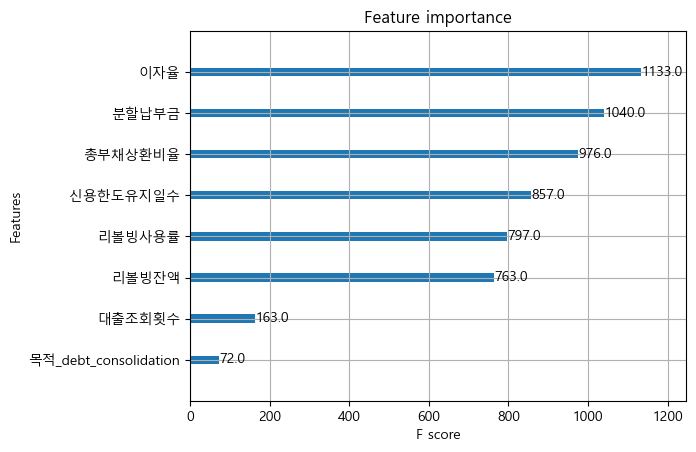

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Train the XGBoost model
model = XGBClassifier(learning_rate=0.3, n_estimators=150, min_child_weight=1, subsample=0.6, colsample_bytree=0.8, max_depth=4,
                                  gamma=0, reg_alpha=0, reg_lambda=1)
model.fit(X_train_2, y_train)

# Plot feature importance
xgb.plot_importance(model)
plt.show()